In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Generate Some Categorical Data

In [36]:
X = np.concatenate((np.random.uniform(0, 5.25, 30), np.random.uniform(4.75, 10, 30)))
S = np.concatenate((np.zeros(30), np.ones(30)))

Text(0, 0.5, 'S')

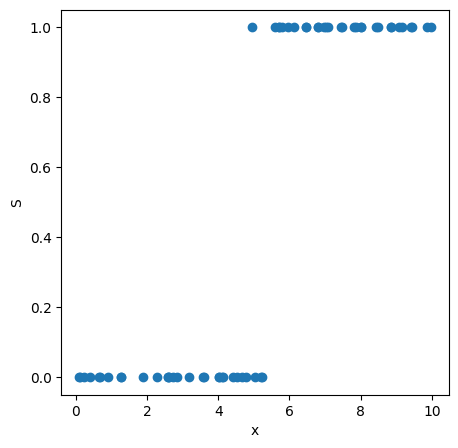

In [37]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(X, S)
plt.xlabel('x')
plt.ylabel('S')

### Normalizing data is extremely important!!!

In [38]:
X = (X - np.mean(X)) / np.std(X)

# Logistic Regression

The logistic regression model is based on fitting a sigmoid $S: X \rightarrow{} [0, 1]$ to the independent variable $X$
$$S = \frac{e^X}{1 + e^X}$$
This $S$ is essentially the likelihood / probability of $X$ falling in category 1. The model is fit by fitting a linear regression model to the log of the odds or the logit function $y: S \rightarrow{} (-\infty, \infty)$ of the likelihood against the observed $X$.
$$y = \log \frac{S}{1-S} = w*X + b = [1 \quad X][b \quad w]^T = \hat{X}\theta$$ 

Except that the best fit line is not found by minimizing the residuals since $y(1) = \infty \text{ and } y(0) = -\infty$ leading to infinite residuals. Instead, the best fit line is found as the one with the maximum likelihood. To do that:

- Project each point at $\pm \infty$ to the candidate line giving the log-odds value of it. 
- Invert the logit function to get the likelihood for each point.
- Multiply likelihoods for all given points OR add log-likelihoods for all points.
- Repeat for all candidate lines and choose the one with maximum likelihood or log-likelihood.

(It is preferred to use log-likelihoods because they take the product of small values in $[0, 1]$ to integral values overcoming the underflow problem in computation which occurs due to the computer not being able to store the veryyy small number)

**Popular Metrics for Evaluating the Model (Goodness of Fit):**

Since $R^2$ cannot be calculated regularly due to the non-finiteness of the $x$ values, many ways have been proposed to calculate an $R^2$ value for the logistic regression model (with no consensus on the best method).

One such metric is *McFadden's Pseudo $R^2$* which is calculated similarly as regular $R^2$ with log-likelihood replacing SSR.
$$R^2 = \frac{LL(overall) - LL(fit)}{LL(overall)}$$
where $LL(overall)$ can be calculated as the log-probability of class 1 compared to the other class by method of frequency in our given data. 

Similarly, the associated $p$ value to get significance of the parameters can be calculated as $2*(LL(fit) - LL(overall))$. 

### Weakness

Logistic regression assumes that a sigmoid $S$ can be fit to the data's likelihood. This assumes a relatively straightforward relationship between the classes and the independent variable. 

# Define Functions for Sigmoid and Logit

Note: They are inverse functions of each other

In [39]:
def sigmoid(x_):
    return 1 / (1 + np.exp(-x_))

def logit(S_):
    return np.log(S_ / (1 - S_))

# Defining Log-Likelihood for Logistic Regression

The log-likelihood is defined as following for points $(x, S)$ where $S$ represents the probability of each class. 

$$L(\theta) = \sum_i [S_i \log{S(\hat{y}_i)} + (1 - S_i) \log{(1 - S(\hat{y}_i))}]$$

where $S_i$ are the given probabilities and $S(\hat{y}_i)$ are the predicted probabilities. 

In [40]:
def log_likelihood(X, S, theta):
    S_ = sigmoid(X*theta)
    return np.sum(S * np.log(S_) + (1 - S) * np.log(1 - S_))

# Initialize Weight and Bias as $\theta$

In [41]:
theta = np.zeros(1)
theta

array([0.])

# Define Function for Gradient Descent

Logsitic regression uses the gradient for log-likelihood. But since we have to _maximize_ the likelihood, the descent should use the negative of the derivative. 

$$\frac{d(L)}{d\theta} = X^T (S - S(\hat{y}))$$

In [42]:
def grad_descent(X, S, theta, lr=0.0001):

    dldt = -X.T @ (S - sigmoid(X*theta))
    theta = theta - lr*dldt

    likely = log_likelihood(X, S, theta)

    return theta, likely

# Run All Epochs to Find Best theta

In [43]:
for epoch in range(10000):
    theta, likely = grad_descent(X, S, theta, lr=0.001)
    if epoch % 1000 == 0:
        print(f'Iteration {epoch}, likelihood {likely}.')

Iteration 0, likelihood -40.960159991599575.
Iteration 1000, likelihood -8.282302191248437.
Iteration 2000, likelihood -6.798355252635775.
Iteration 3000, likelihood -6.127779652196173.
Iteration 4000, likelihood -5.725623998598593.
Iteration 5000, likelihood -5.451754566281654.
Iteration 6000, likelihood -5.251048044835833.
Iteration 7000, likelihood -5.0967151623367055.
Iteration 8000, likelihood -4.973930085077541.
Iteration 9000, likelihood -4.873726221388897.


# Plot the Best Fit Line

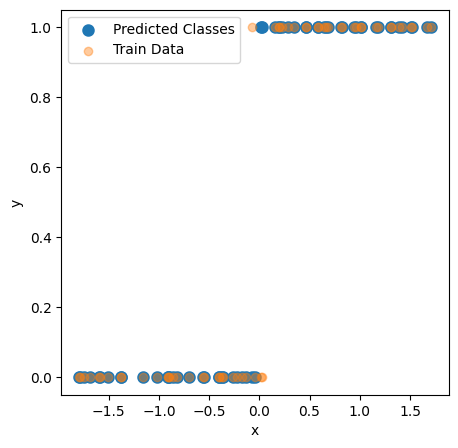

In [44]:
pred = (sigmoid(X * theta) >= 0.5).astype(int)

fig = plt.figure(figsize=(5, 5))
plt.scatter(X, pred, linewidth=3, label='Predicted Classes')
plt.scatter(X, S, alpha=0.4, label='Train Data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

# A Neater Approach With OOP

In [45]:
class LogisticRegressionEstimator():
    def __init__(self, lr=0.0001, epochs=10000):
        self.lr = lr
        self.epochs = epochs
        self.theta = None
        self.likely = None
    
    def initialize_parameters(self, X):
        self.theta = np.zeros(1)
        self.likely = 0

    def sigmoid(self, x_):
        return 1 / (1 + np.exp(-x_))

    def logit(self, S_):
        return np.log(S_ / (1 - S_))
    
    def log_likelihood(self, X, S):
        S_ = self.sigmoid(X*self.theta)
        return np.sum(S * np.log(S_) + (1 - S) * np.log(1 - S_))

    def update_likely(self, X, S):
        self.likely = self.log_likelihood(X, S)
    
    def grad_descent(self, X, S):

        dldt = np.sum(X * (S - self.sigmoid(X * self.theta)))
        self.theta = self.theta + self.lr * dldt

        self.update_likely(X, S)
    
    def fit(self, X, S):

        self.initialize_parameters(X)

        for _ in range(self.epochs):
            self.grad_descent(X, S)

    def predict(self, X, thresh):
        return (self.sigmoid(X * self.theta) >= thresh).astype(int)
    
    def return_parameters(self):
        print(f'Theta is {self.theta}, log-likelihood is {self.likely}.')
        return self.theta, self.likely

In [56]:
logreg = LogisticRegressionEstimator(lr=0.001, epochs=10000)
logreg.fit(X, S)

In [57]:
theta, log_likelihood = logreg.return_parameters()

Theta is [9.16081329], log-likelihood is -4.790394263776146.


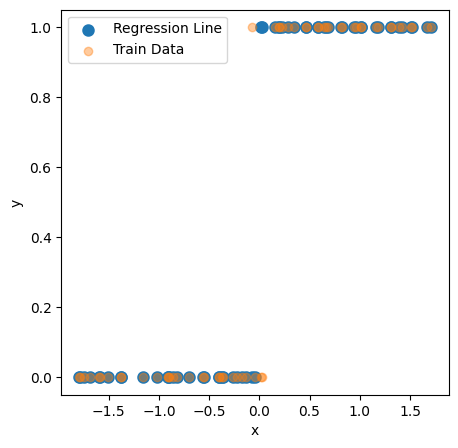

In [58]:
pred = logreg.predict(X, thresh=0.5)

fig = plt.figure(figsize=(5, 5))
plt.scatter(X, pred, linewidth=3, label='Regression Line')
plt.scatter(X, S, alpha=0.4, label='Train Data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

# Make Some New X, S for Prediction Using Similar Scheme As Train Data

(Could have split data into test and train instead of doing this)

In [59]:
num = 20
X_test = np.concatenate((np.random.uniform(3, 5.25, num), np.random.uniform(4.75, 7, num)))
X_test = (X_test - np.mean(X_test)) / np.std(X_test)
S_test = np.concatenate((np.zeros(num), np.ones(num)))

In [60]:
predictions = logreg.predict(X_test, thresh=0.5)

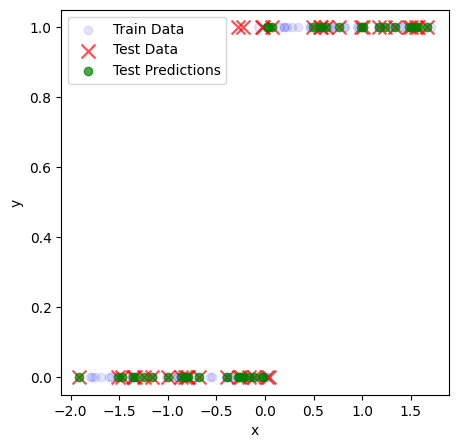

In [61]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(X, S, alpha=0.1, c='b', label='Train Data')
plt.scatter(X_test, S_test, alpha=0.7, c='r', marker='x', s=100, label='Test Data')
plt.scatter(X_test, predictions, alpha=0.7, c='g', label='Test Predictions')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

# Make a Confusion Matrix

In [62]:
import pandas as pd

cm = pd.DataFrame(
    0, index=[0, 1], columns=[0, 1]
)

for t, p in zip(S_test, predictions):
    cm.loc[t, p] += 1

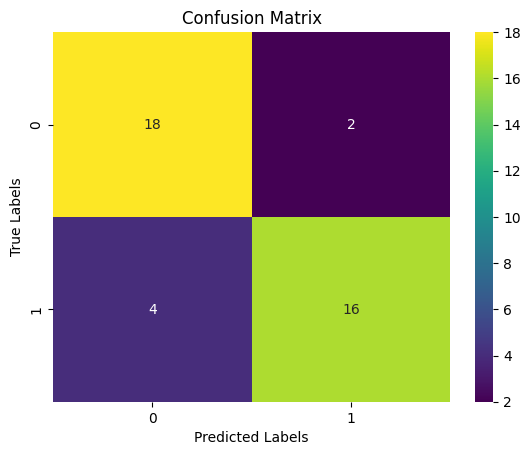

In [63]:
import seaborn as sns

sns.heatmap(cm, annot=True, cmap='viridis', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [64]:
TP = cm.loc[1, 1]
FN = cm.loc[1, 0]
TN = cm.loc[0, 0]
FP = cm.loc[0, 1]

In [68]:
sensitivity = 100*TP / (TP + FN) # Also called Recall or True Positive Rate
sensitivity

80.0

In [69]:
specificity = 100*TN / (TN + FP) # Also 1 - False Positive Rate
specificity

90.0

In [70]:
precision = 100*TP / (TP + FP)
precision

88.88888888888889

# Receiver Operating Curve (ROC) and Precision-Recall Graphs

- Used for finding the best threshold. 
- ROC uses TPR against FPR, while P-R plots TPR against Precision.
- ROC is used when classes are balanced, while P-R is used for imbalanced classes with 0 being majority.

In [71]:
y = []
xROC = []
xPR = []

for i in np.linspace(0, 1, 100, endpoint=True):

    predictions = logreg.predict(X_test, thresh=i)

    cm = pd.DataFrame(0, index=[0, 1], columns=[0, 1])
    for t, p in zip(S_test, predictions):
        cm.loc[t, p] += 1

    TP = cm.loc[1, 1]
    FN = cm.loc[1, 0]
    TN = cm.loc[0, 0]
    FP = cm.loc[0, 1]

    sensitivity = 100*TP / (TP + FN) # Also called Recall or True Positive Rate
    specificity = 100*TN / (TN + FP) # Also 1 - False Positive Rate
    precision = 100*TP / (TP + FP)

    y.append(sensitivity)
    xROC.append(100 - specificity)
    xPR.append(precision)


C:\Users\sunia\AppData\Local\Temp\ipykernel_30164\2734076917.py:20: RuntimeWarning: invalid value encountered in scalar divide
  precision = 100*TP / (TP + FP)


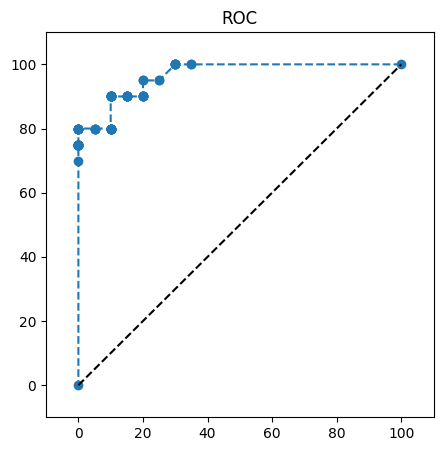

In [72]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(xROC, y)
plt.plot(xROC, y, '--')
plt.plot([0, 100], [0, 100], '--k')
plt.xlim(-10, 110)
plt.ylim(-10, 110)
plt.title('ROC')
plt.show()

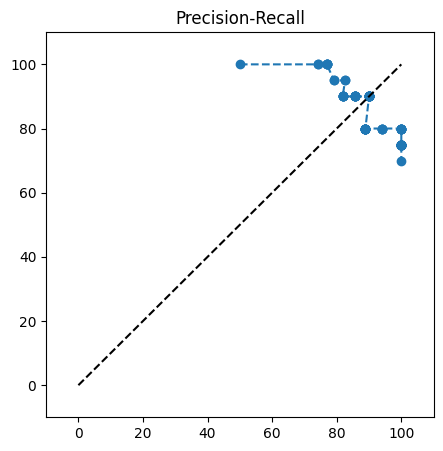

In [73]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(xPR, y)
plt.plot(xPR, y, '--')
plt.plot([0, 100], [0, 100], '--k')
plt.xlim(-10, 110)
plt.ylim(-10, 110)
plt.title('Precision-Recall')
plt.show()

# Area Under the Curve (AOC)

Computed with ROC and used for comparing two different models, say logistic regression and naive bayes. Higher AUC means better model overall.

In [74]:
area = -np.trapz(y, xROC)
area

9662.5